## Loading Packages

In [144]:
from deeplearning import *
from livelossplot import PlotLosses
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from preprocessing import *
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from utils import *
import warnings

# plt.style.use('dark_background')
warnings.filterwarnings("ignore")

def set_seed(seed, device='cpu'):
    """
    Use this to set ALL the random seeds to a fixed value and take out any randomness from cuda kernels
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    
    if torch.cuda.device_count() > 0 and torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False  
        torch.backends.cudnn.enabled   = False

    return True

set_seed(42)

True

### Insuring that training is done on GPU if available

In [145]:
device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")

No GPU available!


## Loading Data

In [146]:
path = "Data/Commodity_Data"
universe_dict = universe_select(path, "Cu")

## Preprocessing

In [147]:
# Renaming the columns to price
universe_dict = price_rename(universe_dict)
# Cleaning the dataset of any erroneous datapoints
universe_dict = clean_dict_gen(universe_dict)
# Making sure that all the points in the window have consistent lenght
universe_dict = truncate_window_length(universe_dict)

# Lg Returns Only
df_full = generate_dataset(universe_dict, lg_returns_only=True, price_only=False)
# Price Only
# df_full = generate_dataset(universe_dict, lg_returns_only=False, price_only=True)

Included Instrument:
cu_shfe
cu_lme
cu_comex_p
cu_comex_s
peso
sol
bdi
ted
vix
skew
gsci


In [148]:
# Both Price and Log Returns
# df_full = generate_dataset(universe_dict, lg_returns_only=False, price_only=False)

In [149]:
# Raw Price Target
# df_target = df_full[["price_cu_lme"]]
# df_target = df_target.shift(-5)
# df_full = df_full[df_full.columns.drop(list(df_full.filter(regex='price')))]

The target column represents the log returns at one forecast length out in the future for the instrument of interest (aluminium or copper prices on the London Metals Exchange). 

To normalise the independent variables, the 1 day log returns between closing prices have been used.

In [150]:
# Visualise the plots
# visualise_universe(universe_dict)
df = df_full[["target"]]

In [151]:
df_full.head(5)
# df_full.tail(5)

,cu_shfe,cu_lme,cu_comex_p,cu_comex_s,peso,sol,bdi,ted,vix,skew,gsci,target
date,,,,,,,,,,,,
2006-09-13,0.001583,-0.013602,0.000590,0.055554,-0.000558,0.000307,0.029244,-0.004276,-0.064091,-0.048458,0.002624,-0.001404
2006-09-14,0.025695,-0.006098,-0.003100,-0.104881,0.000707,-0.001692,0.018715,0.005088,0.032559,-0.008086,-0.010694,0.021675
2006-09-15,-0.027710,-0.021468,-0.019557,0.041104,-0.001172,0.000154,0.012050,0.002636,0.018019,0.124060,-0.004952,0.043012
2006-09-18,0.006177,0.024153,0.030146,0.032495,0.000000,-0.000924,0.004920,0.002023,0.001699,-0.060186,0.007824,0.013450
2006-09-19,0.023214,0.007613,-0.012512,0.138083,0.000000,0.000000,-0.000935,-0.000202,0.016835,-0.018385,-0.019642,0.025225


Normalise data

Split into validation data and test data

Use validation to tune hyperparameters

Perform predictions on the test dataset

### Creating dataset for pytorch

In [152]:
df_X = df_full.loc[:, df_full.columns != 'target']
df_y = df_full.loc[:, df_full.columns == 'target']
# df_y = df_target

In [153]:
# Reducing the dataset to containing a threshold 
# amount of variance
n_dim = dimension_selector(df_X, thresh=0.95)
df_X = dimension_reduce(df_X, n_dim)

Number of dimensions: 2
Explained Variance: [0.88762885 0.07697064] 
Explained Variance Sum: 0.9645994834543203


In [154]:
# The input size of each time series window
series_length = 100

# Creating a data structure which is slices of input size
X_train = []
y_train = []

for i in range(series_length, len(df_X)):
    X_train.append(df_X.values[i-series_length:i, :])
    y_train.append(df_y.values[i, 0])
    
X_train, y_train = np.array(X_train), np.array(y_train)

### Hyperparameters

In [155]:
# Hyperparameters
learning_rate = 1e-2
momentum = 0.5
weight_decay = 0

# Batch Parameters
batch_size = 128
test_batch_size = 1000

n_epochs = 2

# Model Parameters
num_features = len(df_X.columns)
hidden_dim = 64
num_layers = 2
output_dim = 1

### Class for LSTM deep learning

In [216]:
class DeepLearning():
    """Class to perform training and validation for a given model"""
    def __init__(self, model, df_X, df_y,
                 n_epochs,
                 optimiser, 
                 window_size,
                 loss_function=torch.nn.MSELoss(size_average=False),
                 device="cpu", 
                 seed=42,
                 debug = True):
        
        # The neural network architecture
        self.model = model
        
        # The optimiser for gradient descent
        self.optimiser = optimiser
        
        # Dataframe of training values
        self.df_X = df_X
        
        # Dataframe of target values
        self.df_y = df_y
        
        # The number of epochs
        self.n_epochs = n_epochs
   
        #self.optimiser = optimiser
        self.loss_function = loss_function
        
        # Whether to run on cpu or gpu
        self.device = device
        
        # The random seed to set
        self.seed = seed
        
        # To activate debug mode
        self.debug = debug
        
        # For training logs
        self.logs = None
        
        # The array of predicted lists for each batch
        self.pred_list = None
        
        assert (type(self.df_X) == pd.DataFrame)
        assert (type(self.df_y) == pd.DataFrame)
        assert (len(self.df_X.index) == len(self.df_y.index))
        assert (len(self.df_X.index) > 0)
        
        self.X_train = None
        self.X_val = None
        self.X_test = None
        
        self.y_train = None
        self.y_val = None
        self.y_test = None
        
        self.window_size = window_size
        self.inspect = None
        
    def train_val_test(self):
        """Splits the dataframes in to a training, validation
        and test set and creates torch tensors from the underlying
        numpy arrays"""
        # Splitting the sets into train, test and validation
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.df_X, self.df_y, test_size=0.2, shuffle=False)
        
        self.X_train, self.X_val, self.y_train, self.y_val = train_test_split(self.X_train, self.y_train, test_size=0.25, shuffle=False)

        if self.debug:
            print("Train Length: \t\t%i\nValidation Length: \t%i\nTest Length:\t\t%i" 
                  % (len(X_train), len(X_val), len(X_test)))
        
        # Performs normalisation
        # This changes the types of the X_train/val/test 
        # from dataframe to arrays
        self.normalise()
        
        # Tensor of training data
        self.X_train = torch.from_numpy(self.X_train).float()
        self.y_train = torch.from_numpy(self.y_train.values).float()

        # Tensor of training labels
        self.X_val = torch.from_numpy(self.X_val).float()
        self.y_val = torch.from_numpy(self.y_val.values).float()

        #  Tensor of test data
        self.X_test = torch.from_numpy(self.X_test).float()
        self.y_test = torch.from_numpy(self.y_test.values).float()

        # Size Check
        if self.debug:
            print("\nInitial Size Check:")
            self.size_check()
    
    
    def size_check(self):
        """Checks the size of the datasets"""
        if self.debug:
            print("\nX Train Shape:\t\t", self.X_train.size())
            print("X Val Shape:\t\t", self.X_val.size())
            print("X Test Shape:\t\t", self.X_test.size())

            print("\ny Train Shape:\t\t", self.y_train.size())
            print("y Val Shape:\t\t", self.y_val.size())
            print("y Test Shape:\t\t", self.y_test.size())
    
    
    def normalise(self):
        """Normalizes the data using MaxMinScaler, which
            was chosen because it preserves the original 
            scale and doesn't reduce effect of outliers"""
        
        scaler = MinMaxScaler()
        
        # Normalize the validation and test set by the same
        # scale as the training data. Needed for training to
        # be correctly scaled
        
        self.X_train = scaler.fit_transform(self.X_train)
        self.X_val = scaler.transform(self.X_val)
        self.X_test = scaler.transform(self.X_test)
        
        """TODO implement output scaling for MTL because 
        otherwise the scale of the different outputs will
        lead to dominance of some tasks"""
        
    
    def create_data_loaders(self):
        """Forms iterators to pipeline in the data"""
        
        # Slices the datasets into their respective windows
        # Beginning at 0 with a step of 1, then rearranging the 
        # columns to be consisten with notation.
        self.X_train= self.X_train.unfold(0, self.window_size, 1).permute(0, 2, 1)
        self.X_val = self.X_val.unfold(0, self.window_size, 1).permute(0, 2, 1)
        self.X_test = self.X_test.unfold(0, self.window_size, 1).permute(0, 2, 1)
        
        # The target values also need to be lined up
        # This reduces the dataset by the window size
        # The [:,;,-1] it to take the value at the end
        # of the window now the beginning
        self.y_train = self.y_train.unfold(0, self.window_size, 1)[:, :, -1]
        self.y_val = self.y_val.unfold(0, self.window_size, 1)[:, :, -1]
        self.y_test = self.y_test.unfold(0, self.window_size, 1)[:, :, -1]
        
        print("\nTime Series Quantity: %i Rolling Window Size: %i Feature Number: %i"
             %(self.X_train.shape[0], self.X_train.shape[1], self.X_train.shape[2]))
        if self.debug:
            print("\nDataset Creation Size Check:")
            self.size_check()
            
        # Create tensor datasets
        train_dataset = TensorDataset(self.X_train, self.y_train)
        val_dataset = TensorDataset(self.X_val, self.y_val)
        test_dataset = TensorDataset(self.X_test, self.y_test)
        
        # Data loaders
        train_data_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=False)
        val_data_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)
        test_data_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)
        
        return train_data_loader, val_data_loader, test_data_loader
    
    
    def train(self, train_data_loader):
        """Performs a single training cycle and returns the
        mean squared error loss for the training dataset"""
        # Sets the model to train mode
        self.model.train()
        
        train_loss = 0.
        
        # List of each batch predictions
        pred_list = []
        
        # The data loader creates batches of data to train
        for i_batch, (X_train_batch, y_train_batch) in enumerate(train_data_loader):
            
            #print('Batch : ', i_batch)
            
            # Sending the data to GPU if available
            X_train_batch = X_train_batch.to(self.device)
            y_train_batch = y_train_batch.to(self.device)
            
            # Zeros the gradients
            self.optimiser.zero_grad()

            # Need to set seed here to make deterministic
            set_seed(42)
        
            # Perform forward pass
            y_pred = self.model(X_train_batch)
            
            # Calculate loss for the batch
            loss = self.loss_function(y_pred, y_train_batch)   

            # Perform backward pass
            loss.backward()   

            # Adding the predictions for this batch to prediction list
            pred_list.append(y_pred)
            
            # Calculate the training loss
            train_loss += (loss * X_train_batch.size()[0]).detach().cpu().numpy()

            # Update Parameters
            self.optimiser.step()               
        
        # Converting an array of batches of predictions to a list of predictions
        self.pred_list = [single_pred for batch in pred_list for single_pred in batch.detach().numpy()]
        
        return train_loss/len(train_data_loader.dataset.tensors[0])
    
    
#     def validate(self, val_data_loader):
#         """Evaluates the performance of the network
#         on unseen validation data"""
#         # Set the model to evaluate mode
#         self.model.eval()
        
#         val_loss = 0.
#         # The data loader creates batches of data to validate
#         for X_val_batch, y_val_batch in val_data_loader:
            
#             # Ensures that the gradients are not updated
#             with torch.no_grad():
                
#                 # Sending the data to GPU if available
#                 X_val_batch = X_val_batch.to(self.device)
#                 y_val_batch = y_val_batch.to(self.device)
            
#                 # Perform forward pass
#                 y_pred = self.model(X_val_batch)

#                 # Calculate loss for the batch
#                 loss = self.loss_function(y_pred, y_val_batch) 
                
#                 # Calculate the validation loss
#                 val_loss += (loss * X_val_batch.size()[0]).detach().cpu().numpy()
            
#         return val_loss/len(val_data_loader.dataset.tensors[0])
    
    
    def training_wrapper(self):
        
        # start timer
        start_time = time.time()

        # set seed
        set_seed(int(self.seed))
        
        # Create data loaders
        train_loader, val_loader, test_loader = learning.create_data_loaders()
        
        # Shows live plot of losses
        liveloss = PlotLosses()
        
        # Begin training
        for epoch in range(self.n_epochs):
            
            logs = {}
            
            train_loss = self.train(train_loader) 
            #val_loss = self.validate(val_loader) 
            
            print("Losses:" , train_loss.item())
            #print("Losses:" ,train_loss.item(), val_loss.item())
            
            logs['' + 'log loss'] = train_loss.item()
            #logs['val_' + 'log loss'] = val_loss.item()
            logs['time'] = time.time() - start_time
            
            #liveloss.update(logs)
            #liveloss.draw()
            
            print("Epoch %i MSE %.2f  Time %.1f" % (epoch, train_loss.item(), (time.time() - start_time)))

In [170]:
class LSTM(nn.Module):
    """A Long Short Term Memory network
    model"""
        
    def __init__(self, num_features, hidden_dim, output_dim,
                 batch_size, series_length, 
                 dropout=0.1, num_layers=2, debug=True):
        
        super(LSTM, self).__init__()
        
        # Number of features
        self.num_features = num_features
        
        # Hidden dimensions
        self.hidden_dim = hidden_dim

        # Number of hidden layers
        self.num_layers = num_layers
        
        # The output dimensions
        self.output_dim = output_dim
        
        # Batch Size
        self.batch_size = batch_size
        
        # Length of sequence
        self.series_length = series_length
        
        # Dropout Probability
        self.dropout = dropout
        
        # Define the LSTM layer
        self.lstm = nn.LSTM(
            input_size = self.num_features, 
            hidden_size =self.hidden_dim,
            num_layers =self.num_layers)

        # Fully Connected Layer
        self.fc1 = nn.Linear(in_features=self.hidden_dim, 
                             out_features=self.hidden_dim)
        
        # Activation function
        self.act = nn.ReLU()
        
        # Output layer
        self.out = nn.Linear(in_features=self.hidden_dim, 
                             out_features=self.output_dim)
        
        """TODO Add fully connected layer and see if that improves"""
        
        
    def init_hidden(self, batch_size):
        """Initialised the hidden state to be zeros"""
        return (torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(device),
                torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(device))
    
    
    def forward(self, x):
        """Forward pass through the neural network"""
        
        """TODO Directly switch these variables in 
        the permute of the dataset"""
        
        # Adjust to a variable batch size 
        batch_size = x.size()[0]
        series_length = x.size()[1]
        
        #print("series_length, batch_size", series_length, batch_size)
        
        assert (series_length == self.series_length)
        
        """TODO Check output of contiguous and non 
        contigious memory"""
        
        # Keeps the dimensions constant regardless of batchsize
        x = x.contiguous().view(series_length, batch_size, -1) 

        # Initialises the hidden states
        h0, c0 = self.init_hidden(batch_size)
        
        # Pass through through lstm layer
        # Only the x is of interest
        x, (hn, cn) = self.lstm(x, (h0, c0))
        
        # Output is seq to seq but only want seq to val
        # So only use the final value of the lstm outputted
        # sequence
        x = x[-1]  
        
        # Fully connected hidden layer
        x = self.act(self.fc1(x))
        
        return self.out(x).view(-1)

In [182]:
model_lstm = LSTM(num_features=num_features, 
             hidden_dim=hidden_dim, 
             series_length = series_length,
             batch_size=batch_size,
             output_dim=output_dim, 
             num_layers=num_layers)

print("num_features %i \nhidden_dim %i\nseries_length %i \nbatch_size %i\noutput_dim %i \nnum_layers %i"
      % (num_features, hidden_dim, series_length, batch_size,output_dim, num_layers))

print('df_X ', df_X.values.shape, '\ndf_y', df_y.values.shape)

num_features 2 
hidden_dim 64
series_length 100 
batch_size 128
output_dim 1 
num_layers 2
df_X  (3333, 2) 
df_y (3333, 1)


In [172]:
# df_X = df_full.loc[:, df_full.columns != 'target']
# df_y = df_full.loc[:, df_full.columns == 'target']
# df_y = df_target

# optimiser = torch.optim.SGD(model_test.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)
optimiser = torch.optim.Adam(model_lstm.parameters(), learning_rate)

"""Do I need to declare a data explicitly in the dataset"""
learning = DeepLearning(model=model_lstm, 
                        df_X=df_X, 
                        df_y=df_y, 
                        n_epochs=3,
                        optimiser=optimiser,
                        window_size=series_length,
                        debug=False)

# Splitting the data into the train, validation and test sets
learning.train_val_test()
learning.training_wrapper()


Time Series Quantity: 1900 Rolling Window Size: 100 Feature Number: 2
Losses: 55.49443156995272
Epoch 0 MSE 55.49  Time 4.0
Losses: 29.887238833778785
Epoch 1 MSE 29.89  Time 7.9
Losses: 28.27406612998561
Epoch 2 MSE 28.27  Time 11.7


### Non class runthrough

In [183]:
X_train = learning.X_train
X_test = learning.X_test
y_train = learning.y_train
y_test = learning.y_test

In [184]:
print(X_train.shape)
print(y_train.shape)

torch.Size([1900, 100, 2])
torch.Size([1900, 1])


In [185]:
dset = TensorDataset(X_train, y_train)

train_loader = DataLoader(dset,
                          batch_size=batch_size,
                          shuffle=False)

In [188]:
model_001= LSTM(num_features=num_features, 
             hidden_dim=hidden_dim, 
             series_length = series_length,
             batch_size=batch_size,
             output_dim=output_dim, 
             num_layers=num_layers)

model_001.parameters

<bound method Module.parameters of LSTM(
  (lstm): LSTM(2, 64, num_layers=2)
  (fc1): Linear(in_features=64, out_features=64, bias=True)
  (act): ReLU()
  (out): Linear(in_features=64, out_features=1, bias=True)
)>

In [189]:
num_epochs = 5
log = np.zeros(num_epochs)
loss_fn = torch.nn.MSELoss(size_average=False)
learning_rate = 1e-3
optimiser = torch.optim.Adam(model_001.parameters(), learning_rate)

observed_list = []
start_time = time.time()

for epoch in range(num_epochs):
    
    pred_list = []
    
    for batch_idx, (X_train_batch, y_train_batch) in enumerate(train_loader):

        if epoch == 0: observed_list.append(y_train_batch)
            
        # Zero out gradients
        optimiser.zero_grad()
        
        # Need to set seed here to make deterministic
        set_seed(42)
        
        # Forward pass
        y_pred = model_001(X_train_batch)

        # Loss Function
        loss = loss_fn(y_pred, y_train_batch)
        log[epoch] = loss.item()

        # Backward pass
        loss.backward()

        # Update parameters
        optimiser.step()
        
        pred_list.append(y_pred)
    
    if epoch % 1 == 0: print("Epoch: %i MSE: %.5f Time: %.3f" % (epoch, loss.item(), (time.time() - start_time)))

Epoch: 0 MSE: 7.44381 Time: 4.519
Epoch: 1 MSE: 5.15418 Time: 8.429
Epoch: 2 MSE: 5.29295 Time: 12.383
Epoch: 3 MSE: 5.29148 Time: 16.182
Epoch: 4 MSE: 5.21630 Time: 20.009


### Plotting

In [178]:
predicted = [single_pred for batch in pred_list for single_pred in batch.detach().numpy()]
observed = [single_pred for batch in observed_list for single_pred in batch.detach().numpy()]

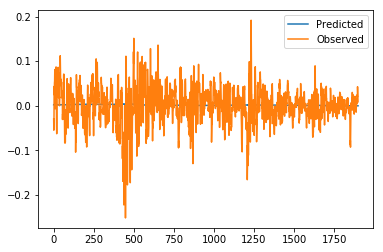

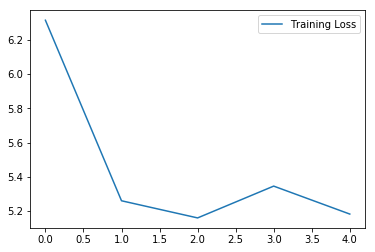

In [179]:
plt.plot(predicted, label="Predicted")
plt.plot(observed, label="Observed")
plt.legend()
plt.show()

plt.figure()
plt.plot(log, label="Training Loss")
plt.legend()
plt.show()

### Data for a toy case

In [190]:
batch_size = 40
# batch_size = 80

In [207]:
X_train = torch.load('X_train.pt').permute(1, 0, 2)
X_test = torch.load('X_test.pt').permute(1, 0, 2)
y_train = torch.load('y_train.pt')
y_test = torch.load('y_test.pt')

y_train = y_train + 10
y_test = y_test + 10

In [208]:
print(X_train.shape)
# 80 series
# 20 is the length of a series
# 1 feature

# X_train [number of series, length of series, feature number]
# y_train [number of series]

torch.Size([80, 20, 1])


In [209]:
dset = TensorDataset(X_train, y_train)

In [210]:
train_loader = DataLoader(dset,
                          batch_size=batch_size,
                          shuffle=False)

In [211]:
model_toy = LSTM(num_features=1, 
             hidden_dim=64, 
             batch_size=40,
             output_dim=1, 
             num_layers=2, 
             series_length=20)

In [212]:
# num_epochs = 10
num_epochs = 1000
log = np.zeros(num_epochs)
loss_fn = torch.nn.MSELoss(size_average=False)
learning_rate = 1e-3
optimiser = torch.optim.Adam(model_toy.parameters(), learning_rate)

observed_list = []
start_time = time.time()

for epoch in range(num_epochs):
    
    pred_list = []
    
    for batch_idx, (X_train_batch, y_train_batch) in enumerate(train_loader):

        if epoch == 0: observed_list.append(y_train_batch)
            
        # Zero out gradients
        optimiser.zero_grad()
        
        # Need to set seed here to make deterministic
        set_seed(42)
        
        # Forward pass
        y_pred = model_toy(X_train_batch)

        # Loss Function
        loss = loss_fn(y_pred, y_train_batch)
        log[epoch] = loss.item()

        # Backward pass
        loss.backward()

        # Update parameters
        optimiser.step()
        
        pred_list.append(y_pred)

    if epoch % 100 == 0: print("Epoch: %i MSE: %.5f Time: %.3f" % (epoch, loss.item(), (time.time() - start_time)))
#     if t % 100 == 0: print("Epoch ", t, "MSE: ", loss.item())

Epoch: 0 MSE: 4086.70020 Time: 0.119
Epoch: 100 MSE: 1.98111 Time: 9.333
Epoch: 200 MSE: 1.98061 Time: 19.444
Epoch: 300 MSE: 1.98056 Time: 26.988
Epoch: 400 MSE: 1.98048 Time: 35.176
Epoch: 500 MSE: 1.98037 Time: 42.274
Epoch: 600 MSE: 1.98024 Time: 49.048
Epoch: 700 MSE: 1.98010 Time: 55.364
Epoch: 800 MSE: 1.97993 Time: 61.779
Epoch: 900 MSE: 1.97975 Time: 68.075


## Plotting predictions

### Toy example

In [213]:
predicted = [single_pred for batch in pred_list for single_pred in batch.detach().numpy()]
observed = [single_pred for batch in observed_list for single_pred in batch.detach().numpy()]

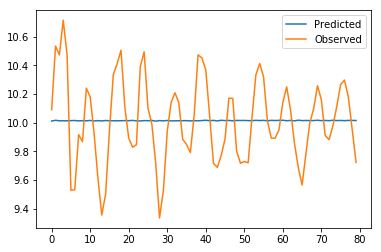

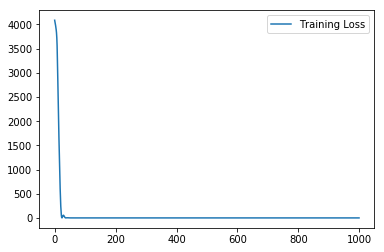

In [214]:
plt.plot(predicted, label="Predicted")
plt.plot(observed, label="Observed")
plt.legend()
plt.show()

plt.figure()
plt.plot(log, label="Training Loss")
plt.legend()
plt.show()

### Plotting

### Class Example

In [134]:
predicted = learning.pred_list
observed = learning.y_train.numpy()

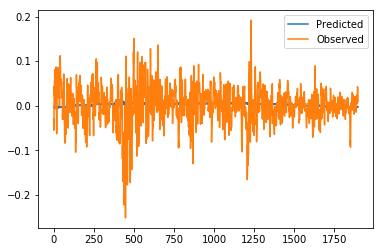

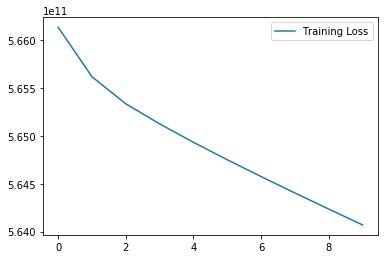

In [137]:
plt.plot(predicted, label="Predicted")
plt.plot(observed, label="Observed")
plt.legend()
plt.show()

plt.figure()
plt.plot(log, label="Training Loss")
plt.legend()
plt.show()

# Results

In [659]:
df = df_full[["target"]]
# Taking t-1 to be the value for t
df["persistance"] = df.shift(1)
df.dropna(inplace=True)
# Calculating metrics for these columns
MSE, MAE, MDE = evaluate(df, "target", "persistance")

In [660]:
print(df[:5])
print(df[-5:])

              target  persistance
date                             
2006-09-14  0.021675    -0.001404
2006-09-15  0.043012     0.021675
2006-09-18  0.013450     0.043012
2006-09-19  0.025225     0.013450
2006-09-20  0.024843     0.025225
              target  persistance
date                             
2019-06-24 -0.000589     0.004104
2019-06-25 -0.026401    -0.000589
2019-06-26 -0.010480    -0.026401
2019-06-27 -0.011358    -0.010480
2019-06-28 -0.015457    -0.011358


In [661]:
# Placing in results dataframe
results = pd.DataFrame(columns={"MSE", "MAE", "MDE"})
results.index.name = 'Name'
results.head()
results.loc["persistance"] = [MSE, MAE, MDE] 
results.head()

,MSE,MAE,MDE
Name,,,
persistance,0.000582,0.017105,0.465585
